## 2 Random Forest and XGBoost
In this section, we will use tree-based models, namely Random Forest and XGboost, to predict student test performance (G3). We will start with all predictors and then present a table showing the importance ranking. In the linear regression analysis, we treated student performance as a continuous variable. But since tree-based models are better-suited for categorical variables, we will create a categorical performance variable G3_cat from the original variable G3.

In Portugal, where our data is collected, universities uses a 0-20 grading scale, which can be translated to the US grading scale from A to F that is more familiar to readers. The table below shows the translation criteria.

| Portugal Grade | US grade | 
| :--- | :---: |
| 18 - 20 | A+ |
| 16 - 17.9 | A |
| 14 - 15.9 | A- |
| 12 - 13.9 | B |
| 10 - 11.9 | C |
| 0 - 9.9 | F |

In addition to letter grade, we also classified students into high-performing (A+, A, and A-) and low-performing (B, C, F) groups. We will call this G3_cat_hl, with high being 1 and low being 0.

We will load the data and create G3_cat and G3_cat_hl here.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


In [38]:
data = pd.read_csv('data/student-por-cleaned.csv')
data['G3_cat'] = np.where(data['G3'] >= 18, 6,
                  np.where(data['G3'] >= 16, 5,
                   np.where(data['G3'] >= 14, 4,
                    np.where(data['G3'] >= 12, 3,
                     np.where(data['G3'] >= 10, 2, 1)))))
data['G3_cat_hl'] = np.where(data['G3'] >= 14, 1, 0)

Again, we will use 80% of the data for training and 20% of the data for testing.

In [39]:
X_rf = data.drop(columns=['G3_cat','G3','G3_cat_hl'])
y_rf = data['G3_cat']

# One-hot encode categorical variables for modeling
X_encoded_rf = pd.get_dummies(X_rf, drop_first=True)

# Train-test split (80/20)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_encoded_rf, y_rf, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train_rf.shape[0]} samples ({X_train_rf.shape[0]/len(y_rf):.1%})")
print(f"  Test set: {X_test_rf.shape[0]} samples ({X_test_rf.shape[0]/len(y_rf):.1%})")
print(f"  Features: {X_train_rf.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train_rf.mean():.2f}, Std: {y_train_rf.std():.2f}")
print(f"  Test  - Mean: {y_test_rf.mean():.2f}, Std: {y_test_rf.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 38 (after one-hot encoding)

Target distribution:
  Train - Mean: 2.79, Std: 1.28
  Test  - Mean: 3.02, Std: 1.40


### 2.1 Random Forest - for letter grade
Here, we fit the random forest model on our training set. First, we use cross-validation to tune the parameters.

In [40]:
from sklearn.model_selection import GridSearchCV

# 1. Define the "skeleton" model (only fixed settings like random_state go here)
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# 2. Define the menu of parameters to test
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'max_features': ['sqrt']
}

# 3. Initialize Grid Search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Or 'roc_auc_ovr'
    verbose=1,
    n_jobs=-1
)

# 4. RUN THE TUNING (This replaces the old .fit command)
print("Tuning model... please wait.")
grid_search.fit(X_train_rf, y_train_rf)

# 5. Extract the winner
# This 'best_rf_model' is what you use for predictions now
best_rf_model = grid_search.best_estimator_

print(f"Best params: {grid_search.best_params_}")

Tuning model... please wait.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}



Final Test Set Results:
  Accuracy: 0.3462
  Test Error Rate: 0.6538
  AUC: 0.7078


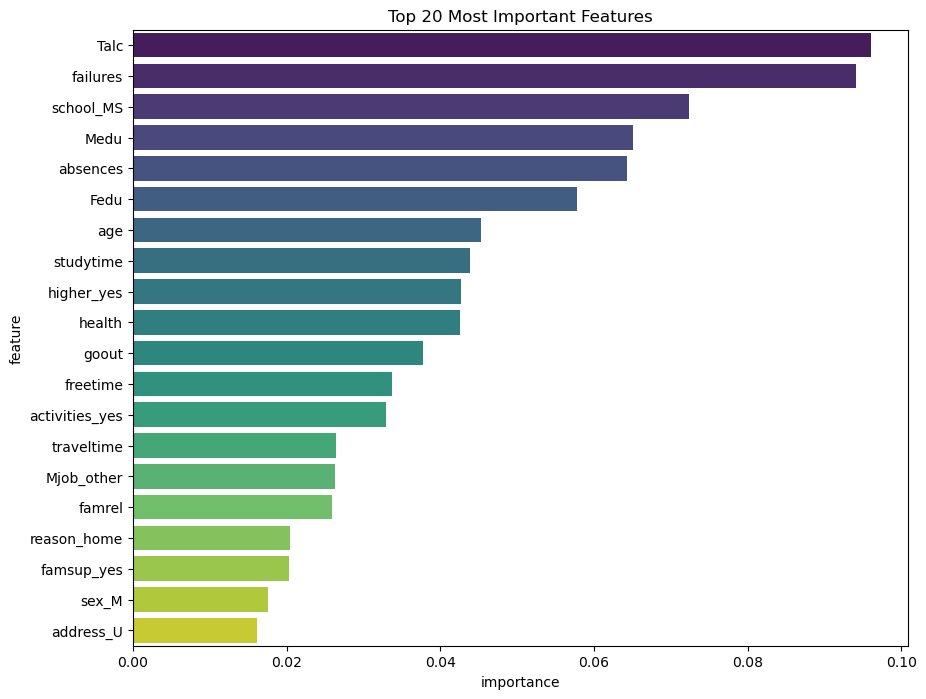

In [41]:
# 1. Initialize Model
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0 # Changed to 0 to avoid printing 5x logs during CV
)


rf_classifier.fit(X_train_rf, y_train_rf)

# 3. Final Predictions on Hold-Out Test Set
y_pred_rf_proba = rf_classifier.predict_proba(X_test_rf)
y_pred_rf = rf_classifier.predict(X_test_rf)

# 4. Metrics
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
auc_rf = roc_auc_score(y_test_rf, y_pred_rf_proba, multi_class='ovr')

print(f"\nFinal Test Set Results:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Test Error Rate: {1 - accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")

# 5. Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train_rf.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)
'''
print("\nTop 20 most important features:")
print(feature_importance.head(20))
'''
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.savefig('graphs/RF_lettergrade_importantfeatures.png', dpi=300, bbox_inches='tight')
plt.show()



Let's look at the confusion matrix to see where is the model failing at.

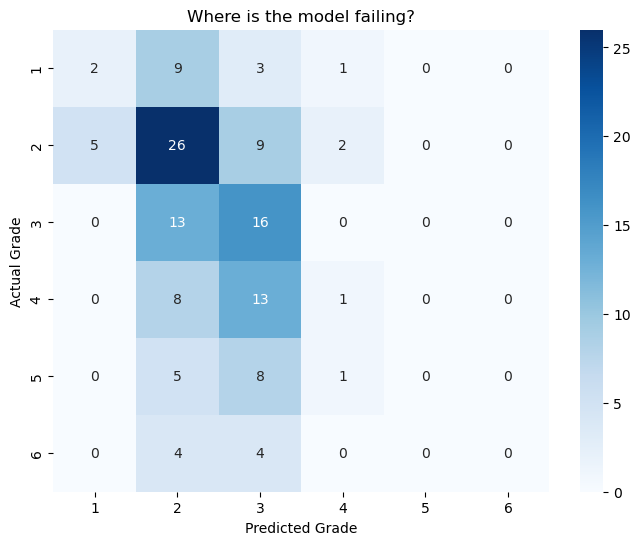

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the matrix
cm = confusion_matrix(y_test_rf, y_pred_rf)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1,2,3,4,5,6], 
            yticklabels=[1,2,3,4,5,6])
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.title('Where is the model failing?')
plt.savefig('graphs/RF_lettergrade_confusionmatrix.png', dpi=300, bbox_inches='tight')

plt.show()

And here is the ROC graph.

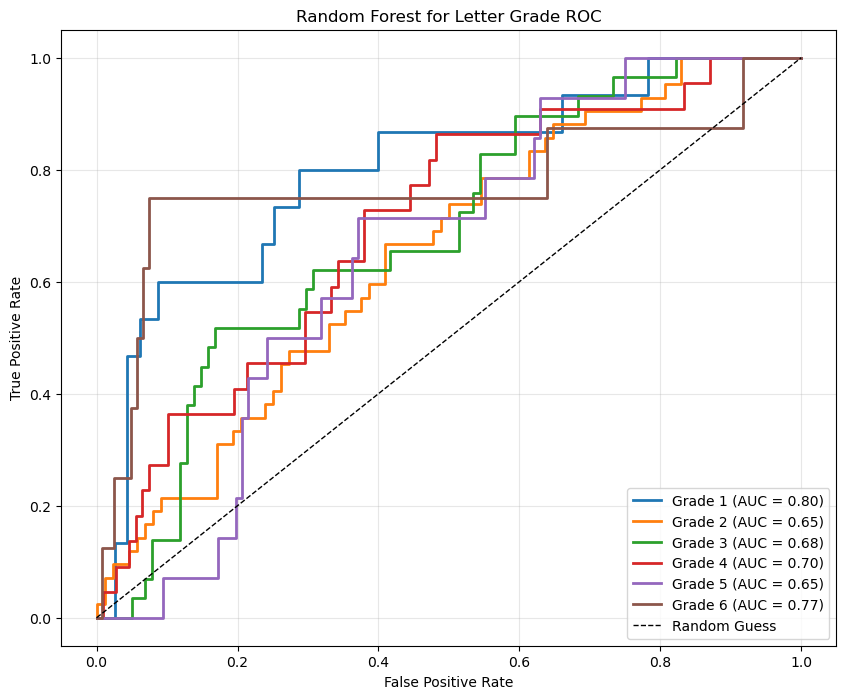

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

classes = [1, 2, 3, 4, 5, 6]
y_test_bin = label_binarize(y_test_rf, classes=classes)

# 2. Setup the Plot
plt.figure(figsize=(10, 8))

# 3. Loop through each class and plot its curve
for i, class_label in enumerate(classes):
    # Calculate FPR and TPR for just this class vs. all others
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_rf_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'Grade {class_label} (AUC = {roc_auc:.2f})')

# 4. Plot the "Random Guess" line
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess')

# 5. Final Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest for Letter Grade ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('graphs/RF_lettergrade_ROC.png', dpi=300, bbox_inches='tight')

plt.show()

### 2.2 Random Forest - for performance

In [44]:
X_rf = data.drop(columns=['G3_cat','G3','G3_cat_hl'])
y_rf = data['G3_cat_hl']

# One-hot encode categorical variables for modeling
X_encoded_rf = pd.get_dummies(X_rf, drop_first=True)

# Train-test split (80/20)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_encoded_rf, y_rf, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train_rf.shape[0]} samples ({X_train_rf.shape[0]/len(y_rf):.1%})")
print(f"  Test set: {X_test_rf.shape[0]} samples ({X_test_rf.shape[0]/len(y_rf):.1%})")
print(f"  Features: {X_train_rf.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train_rf.mean():.2f}, Std: {y_train_rf.std():.2f}")
print(f"  Test  - Mean: {y_test_rf.mean():.2f}, Std: {y_test_rf.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 38 (after one-hot encoding)

Target distribution:
  Train - Mean: 0.29, Std: 0.45
  Test  - Mean: 0.34, Std: 0.48


Again, we use CV to tune the model.

In [45]:
from sklearn.model_selection import GridSearchCV

# 1. Define the "skeleton" model (only fixed settings like random_state go here)
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# 2. Define the menu of parameters to test
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'max_features': ['sqrt']
}

# 3. Initialize Grid Search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Or 'roc_auc_ovr'
    verbose=1,
    n_jobs=-1
)

# 4. RUN THE TUNING (This replaces the old .fit command)
print("Tuning model... please wait.")
grid_search.fit(X_train_rf, y_train_rf)

# 5. Extract the winner
# This 'best_rf_model' is what you use for predictions now
best_rf_model = grid_search.best_estimator_

print(f"Best params: {grid_search.best_params_}")

Tuning model... please wait.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}



Random Forest Results:
  Accuracy: 0.6615
  Test Error Rate: 0.3385
  AUC: 0.7400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


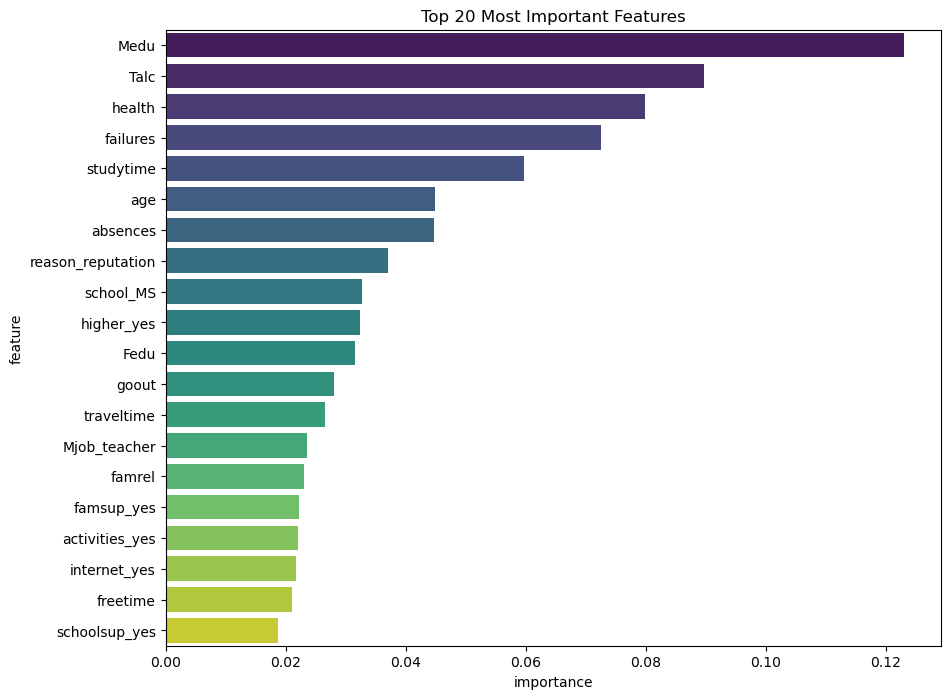

In [46]:

subset_size = 5000
X_train_rf = X_train_rf.iloc[:subset_size]
y_train_rf = y_train_rf.iloc[:subset_size]

rf_classifier = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=10,             # Maximum tree depth
    min_samples_split=20,     # Minimum samples to split
    min_samples_leaf=10,      # Minimum samples in leaf
    max_features='sqrt',      # Number of features for best split
    random_state=42,
    n_jobs=-1,                # Use all cores
    verbose=1
)

rf_classifier.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_rf_proba = rf_classifier.predict_proba(X_test_rf)[:, 1]
y_pred_rf = rf_classifier.predict(X_test_rf)

# Metrics
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
auc_rf = roc_auc_score(y_test_rf, y_pred_rf_proba)

print(f"\nRandom Forest Results:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Test Error Rate: {1 - accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_rf.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

#print("\nTop 20 most important features:")
#print(feature_importance.head(20))
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.savefig('graphs/RF_performance_importantfeatures.png', dpi=300, bbox_inches='tight')
plt.show()

We draw a confusion matrix to see where is the model failing.

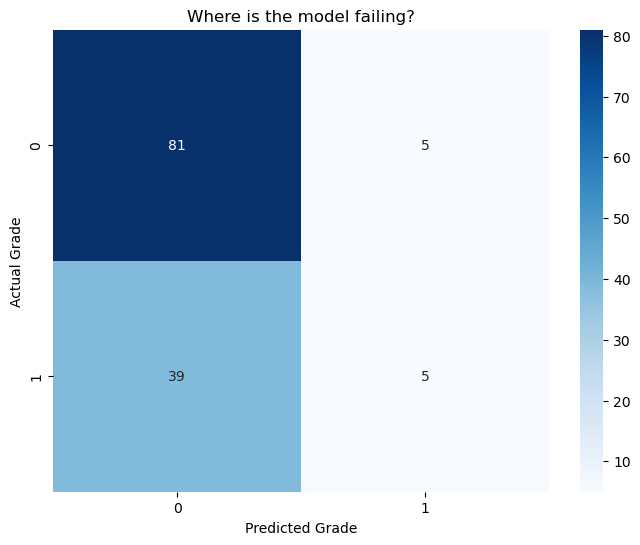

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the matrix
cm = confusion_matrix(y_test_rf, y_pred_rf)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0,1], 
            yticklabels=[0,1])
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.title('Where is the model failing?')
plt.savefig('graphs/RF_performance_confusionmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

Let's look at the ROC curve.

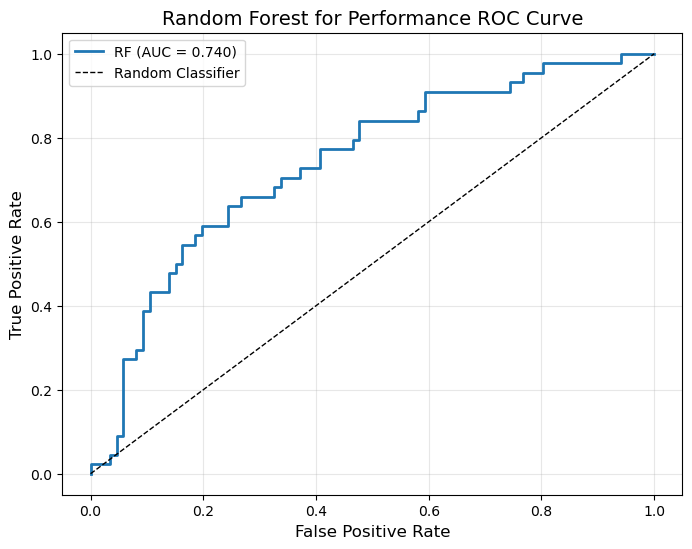

In [49]:
fpr, tpr, thresholds = roc_curve(y_test_rf, y_pred_rf_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'RF (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest for Performance ROC Curve', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.savefig('graphs/RF_performance_ROC.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Xgboost - for letter grade
We will first split the training and testing set

In [31]:
X_xg = data.drop(columns=['G3_cat','G3','G3_cat_hl'])
y_xg = data['G3_cat']

# One-hot encode categorical variables for modeling
X_encoded_xg = pd.get_dummies(X_xg, drop_first=True)

# Train-test split (80/20)
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(
    X_encoded_xg, y_xg, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train_xg.shape[0]} samples ({X_train_xg.shape[0]/len(y_xg):.1%})")
print(f"  Test set: {X_test_xg.shape[0]} samples ({X_test_xg.shape[0]/len(y_xg):.1%})")
print(f"  Features: {X_train_xg.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train_xg.mean():.2f}, Std: {y_train_xg.std():.2f}")
print(f"  Test  - Mean: {y_test_xg.mean():.2f}, Std: {y_test_xg.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 38 (after one-hot encoding)

Target distribution:
  Train - Mean: 2.79, Std: 1.28
  Test  - Mean: 3.02, Std: 1.40


In [32]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. CRITICAL FIX: Shift labels to start at 0
# If your classes are 1-6, this makes them 0-5.
y_train_fixed = y_train_xg - 1

# 2. Configure for Multi-Class
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # 'softprob' gives probabilities (needed for ROC later)
    eval_metric='mlogloss',      # Multi-class Log Loss
    num_class=6,                 # Explicitly tell it there are 6 classes
    use_label_encoder=False,
    random_state=42
)

# 3. Setup Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4. Run Tuning
print("Tuning XGBoost (Multi-Class)... please wait.")
xgb_search.fit(X_train_xg, y_train_fixed)

print(f"Best Accuracy: {xgb_search.best_score_:.4f}")

Tuning XGBoost (Multi-Class)... please wait.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" }

Best Accuracy: 0.4085


Then, we use CV to fine tune the parameters.

Test Accuracy:  0.3231
Test Error Rate: 0.6769


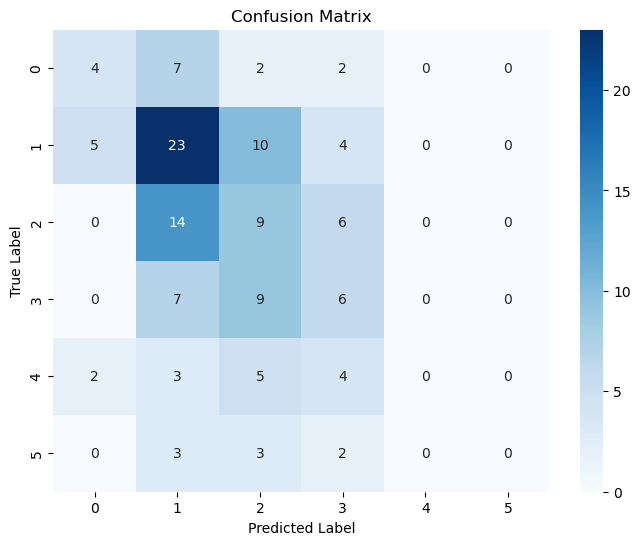

            Feature  Importance
5          failures    0.071356
12        school_MS    0.058558
35       higher_yes    0.046083
25      reason_home    0.033985
11             Talc    0.031984
36     internet_yes    0.030785
1              Medu    0.030234
30    schoolsup_yes    0.030002
28  guardian_mother    0.028534
18       Mjob_other    0.028495
3        traveltime    0.027577
2              Fedu    0.026766
14        address_U    0.026208
4         studytime    0.026115
10         absences    0.025169
29   guardian_other    0.024506
9            health    0.024287
6            famrel    0.023905
23    Fjob_services    0.023846
34      nursery_yes    0.023770


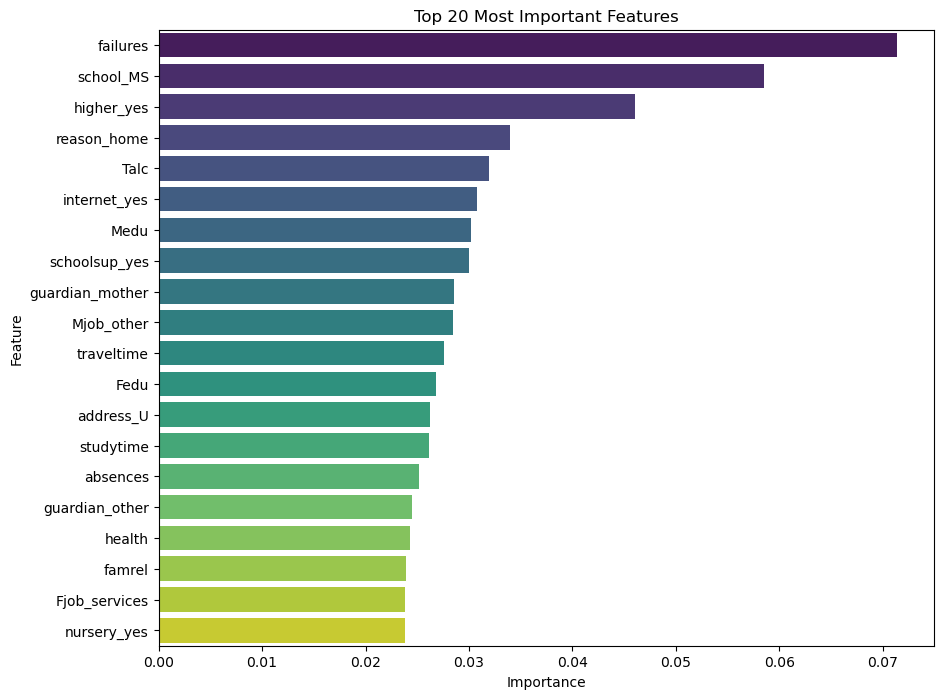

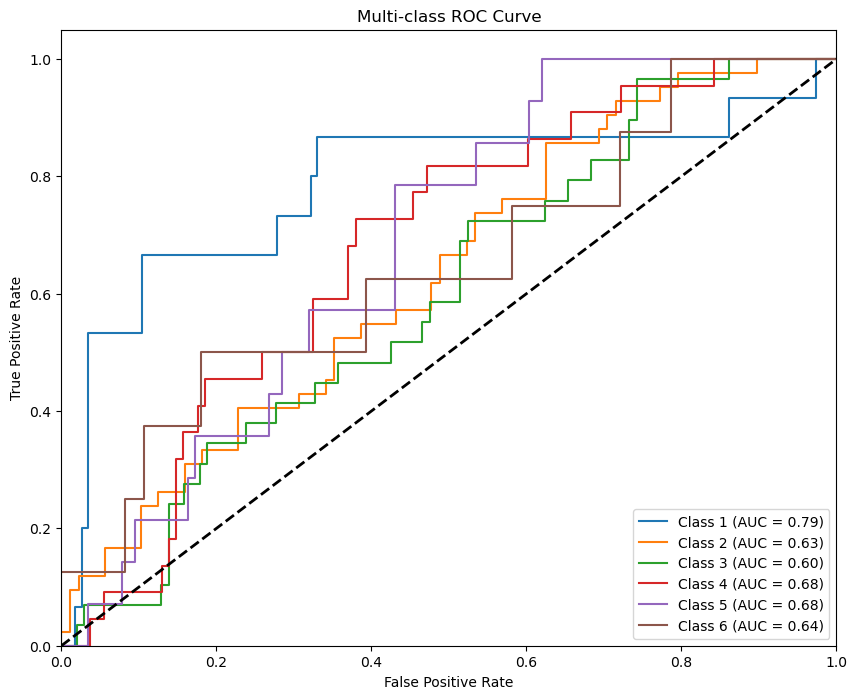

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ==========================================
# 0. PREPARE THE DATA
# ==========================================
# Get the best model from your search
best_xgb = xgb_search.best_estimator_

# IMPORTANT: Fix test labels just like you did for train (shift 1-6 to 0-5)
# If you used LabelEncoder, use: y_test_xg = le.transform(y_test_xg)
y_test_xg_fixed = y_test_xg - 1 

# Make predictions
y_pred = best_xgb.predict(X_test_xg)
y_prob = best_xgb.predict_proba(X_test_xg) # Needed for ROC

# ==========================================
# 1. TEST ERROR RATE
# ==========================================
accuracy = accuracy_score(y_test_xg_fixed, y_pred)
error_rate = 1 - accuracy
print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Test Error Rate: {error_rate:.4f}")

# ==========================================
# 2. CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_test_xg_fixed, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('graphs/xg_lettergrade_confusionmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. TOP 20 FEATURE IMPORTANCE
# ==========================================
# Get feature importance
importances = best_xgb.feature_importances_
feature_names = X_train_xg.columns 

# Create a DataFrame and sort
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_20_features = feature_df.sort_values(by='Importance', ascending=False).head(20)
print(top_20_features)
# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Most Important Features')
plt.savefig('graphs/xg_lettergrade_importantfeatures.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 4. ROC CURVE (Multi-class)
# ==========================================
# We must binarize the output for multi-class ROC plotting
n_classes = 6
y_test_bin = label_binarize(y_test_xg_fixed, classes=[0, 1, 2, 3, 4, 5])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Add back +1 to the label name so the legend makes sense (Class 1-6)
    original_label = i + 1 
    plt.plot(fpr[i], tpr[i], label=f'Class {original_label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.savefig('graphs/xg_lettergrade_ROC.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.4 Xgboost - for performance

In [34]:
X_xg = data.drop(columns=['G3_cat','G3','G3_cat_hl'])
y_xg = data['G3_cat_hl']

# One-hot encode categorical variables for modeling
X_encoded_xg = pd.get_dummies(X_xg, drop_first=True)

# Train-test split (80/20)
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(
    X_encoded_xg, y_xg, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train_xg.shape[0]} samples ({X_train_xg.shape[0]/len(y_xg):.1%})")
print(f"  Test set: {X_test_xg.shape[0]} samples ({X_test_xg.shape[0]/len(y_xg):.1%})")
print(f"  Features: {X_train_xg.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train_xg.mean():.2f}, Std: {y_train_xg.std():.2f}")
print(f"  Test  - Mean: {y_test_xg.mean():.2f}, Std: {y_test_xg.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 38 (after one-hot encoding)

Target distribution:
  Train - Mean: 0.29, Std: 0.45
  Test  - Mean: 0.34, Std: 0.48


In [35]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# 2. Initialize the XGBoost Classifier
# Crucial: Set objective to 'binary:logistic' here
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# 3. Set up the Search (RandomizedSearchCV is usually faster than Grid)
# You can switch to GridSearchCV if you prefer exhaustive search
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,            # Number of combinations to try
    scoring='accuracy',   # Metric to optimize
    cv=3,                 # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1             # Use all CPU cores
)

# 4. Run the Tuning
print("Tuning XGBoost (Binary)... please wait.")
xgb_search.fit(X_train_xg, y_train_xg)

# 5. Get the Best Model
best_xgb_model = xgb_search.best_estimator_

print(f"Best Parameters found: {xgb_search.best_params_}")
print(f"Best CV Accuracy: {xgb_search.best_score_:.4f}")

Tuning XGBoost (Binary)... please wait.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" }

Best Parameters found: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV Accuracy: 0.7534


Test Accuracy:  0.7538
Test Error Rate: 0.2462


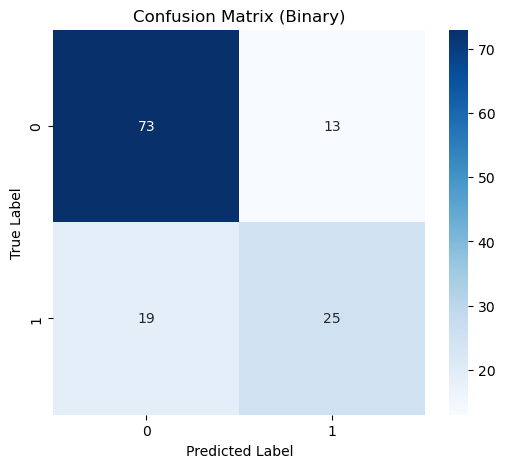

              Feature  Importance
5            failures    0.130399
30      schoolsup_yes    0.070715
35         higher_yes    0.058992
4           studytime    0.038988
1                Medu    0.033882
27  reason_reputation    0.026953
9              health    0.026219
34        nursery_yes    0.025664
11               Talc    0.025486
31         famsup_yes    0.025456
26       reason_other    0.025419
36       internet_yes    0.024660
32           paid_yes    0.024607
15        famsize_LE3    0.024601
20       Mjob_teacher    0.024188
0                 age    0.023588
3          traveltime    0.023319
14          address_U    0.023083
17        Mjob_health    0.022007
28    guardian_mother    0.021037


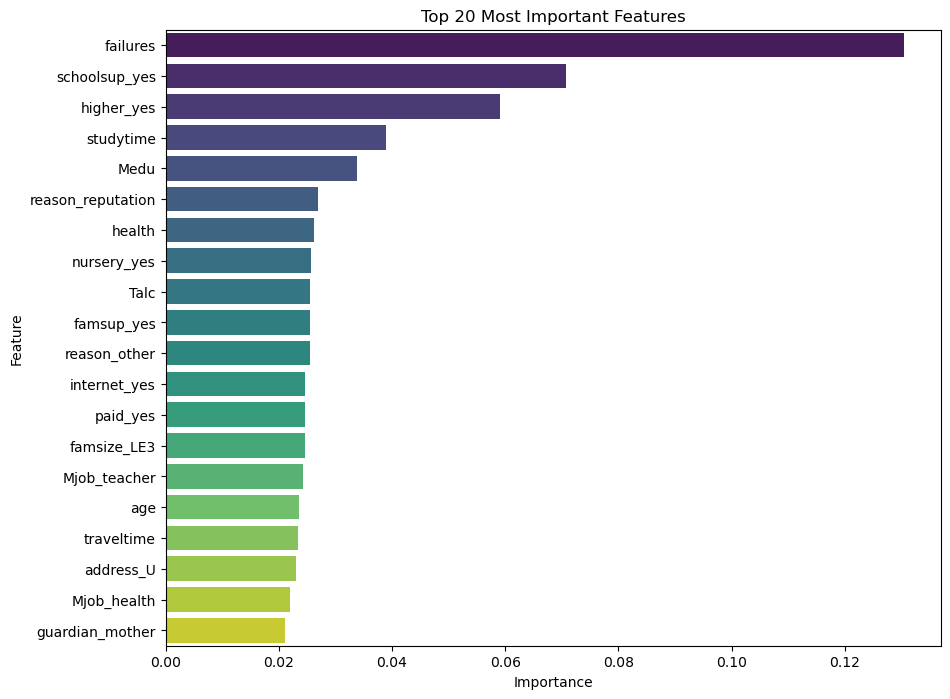

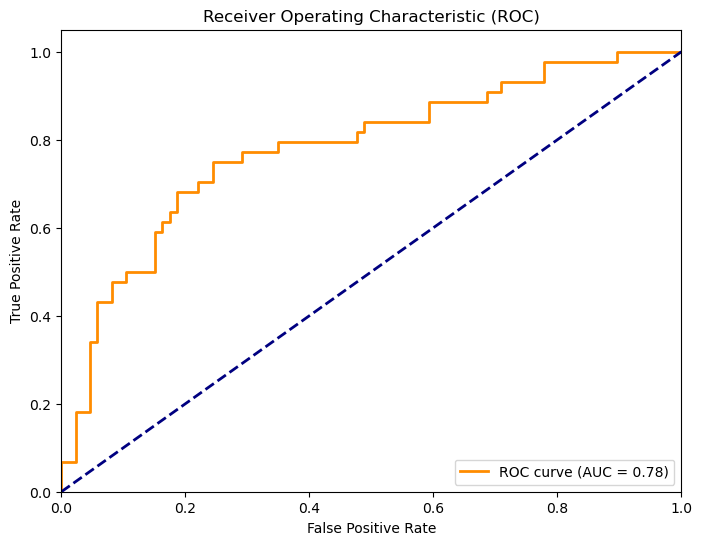

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# ==========================================
# 0. PREPARE THE DATA
# ==========================================
best_xgb = xgb_search.best_estimator_

# Get predictions
y_pred = best_xgb.predict(X_test_xg)

# Get probabilities for the POSITIVE class (Class 1) only
# .predict_proba returns [prob_class_0, prob_class_1], we want the second column
y_prob = best_xgb.predict_proba(X_test_xg)[:, 1]

# ==========================================
# 1. TEST ERROR RATE
# ==========================================
accuracy = accuracy_score(y_test_xg, y_pred)
error_rate = 1 - accuracy

print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Test Error Rate: {error_rate:.4f}")

# ==========================================
# 2. CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_test_xg, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Binary)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('graphs/xg_performance_confusionmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. TOP 20 FEATURE IMPORTANCE
# ==========================================
importances = best_xgb.feature_importances_
feature_names = X_train_xg.columns 

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_20_features = feature_df.sort_values(by='Importance', ascending=False).head(20)
print(top_20_features)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Most Important Features')
plt.savefig('graphs/xg_performance_importantfeatures.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 4. ROC CURVE (Binary)
# ==========================================
# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test_xg, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('graphs/xg_performance_ROC.png', dpi=300, bbox_inches='tight')

plt.show()